# Movies

_We live in a box of space and time. Movies are windows in its walls. They allow us to enter other minds, not simply in the sense of identifying with the characters, although that is an important part of it, but by seeing the world as another person sees it._ - Roger Ebert

## Setup and data cleaning

Caveat: split years....

In [1]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
from numpy import NaN
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Import movies (IMDB)
title_basics = pd.read_csv('../data/title.basics.tsv',delimiter='\t',encoding='utf-8-sig', low_memory=False)

# Import ratings
title_ratings = pd.read_csv('../data/title.ratings.tsv',delimiter='\t',encoding='utf-8-sig')

# Import crew
title_crew = pd.read_csv('../data/title.crew.tsv',delimiter='\t',encoding='utf-8-sig')

# Import name basics
name_basics = pd.read_csv('../data/name.basics.tsv',delimiter='\t',encoding='utf-8-sig')

# Import box office data (BoxOfficeMojo)
box_office = pd.read_csv('../data/boxoffice.csv')

# Import Oscar data (https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films)
oscars = pd.read_csv('../data/oscars_cleaned.csv')

#Import movies (TMDB)
tmdb_5000_movies = pd.read_csv('../data/tmdb_5000_movies.csv')

In [4]:
# Filter non-movies, adult movies
title_filtered = title_basics[title_basics['titleType']=='movie']
title_filtered = title_filtered[title_filtered['isAdult']==0]

In [5]:
# Split out genres and join
genres_split = title_filtered["genres"].str.split(",", n=2, expand=True)
joined = title_filtered.join(genres_split)

# Rename and drop some columns
cleaned = joined.rename(columns = {'tconst':'IMDB ID', 'titleType': 'Type', 'primaryTitle': 'Title', 'originalTitle': 'Title (original)', 'startYear': 'Year', 'runtimeMinutes': 'Runtime (min)', 0:'Genre (main)', 1:'Genre (sub 1)', 2:'Genre (sub 2)'})
cleaned = cleaned.drop(columns=['endYear', 'genres', 'Genre (sub 1)', 'Genre (sub 2)', 'Title (original)'])

In [6]:
# Merge basic set and rating
with_ratings = cleaned.set_index('IMDB ID').join(title_ratings.set_index('tconst'))
with_ratings = with_ratings.rename(columns = {'averageRating': 'Rating (avg.)', 'numVotes': 'Votes'})

# Merge box office and Oscars
merged = pd.merge(box_office, oscars, left_on='title', right_on='Film', how='outer')

In [12]:
# Merge both of above to make combined set
combined = with_ratings.merge(merged,how='left', left_on='Title', right_on='title')

# Drop, rename, change \N to NaN
combined = combined.drop(['Type', 'isAdult', 'Year_y', 'year', 'rank', 'title', 'Film'], axis=1)
combined = combined.rename(columns = {'Year_x': 'Year', 'studio': 'Studio', 'lifetime_gross': 'Gross (lifetime)'})
combined = combined.replace(r'\\N','NaN', regex=True)
combined = combined[combined['Runtime (min)']!='NaN']
combined = combined[combined['Genre (main)']!='NaN']

# Convert NaN to 0 for Awards and Nominiations
combined['Awards']=combined['Awards'].fillna(0)
combined['Nominations']=combined['Nominations'].fillna(0)

In [11]:
combined.head()

,Title,Year,Runtime (min),Genre (main),Rating (avg.),Votes,Studio,Gross (lifetime),Awards,Nominations
0,Miss Jerry,1894,45,Romance,5.9,152.0,NaN,NaN,0.0,0.0
1,The Corbett-Fitzsimmons Fight,1897,20,Documentary,5.2,343.0,NaN,NaN,0.0,0.0
4,The Story of the Kelly Gang,1906,70,Biography,6.1,570.0,NaN,NaN,0.0,0.0
9,The Fairylogue and Radio-Plays,1908,120,Adventure,5.0,35.0,NaN,NaN,0.0,0.0
57,Don Juan de Serrallonga,1910,58,Adventure,3.1,11.0,NaN,NaN,0.0,0.0


In [14]:
#update dataframe to start plots
#change both start/end times to 'datetime' format

tmdb_5000_movies['releaseDate'] = pd.to_datetime(tmdb_5000_movies['release_date'])
tmdb_5000_movies.releaseDate.dt.strftime('%d-%m-%y')
tmdb_5000_movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,releaseDate
0,385907,"[{""id"": 18, ""name"": ""Drama""}]",NaN,3059,"[{""id"": 279, ""name"": ""usa""}, {""id"": 2487, ""nam...",en,Intolerance,"The story of a poor young woman, separated by ...",3.232447,"[{""name"": ""Triangle Film Corporation"", ""id"": 1...",...,9/4/1916,8394751,197.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Cruel Hand of Intolerance,Intolerance,7.4,60,1916-09-04


In [15]:
tmdb_5000_movies['month'] = tmdb_5000_movies['releaseDate'].dt.month

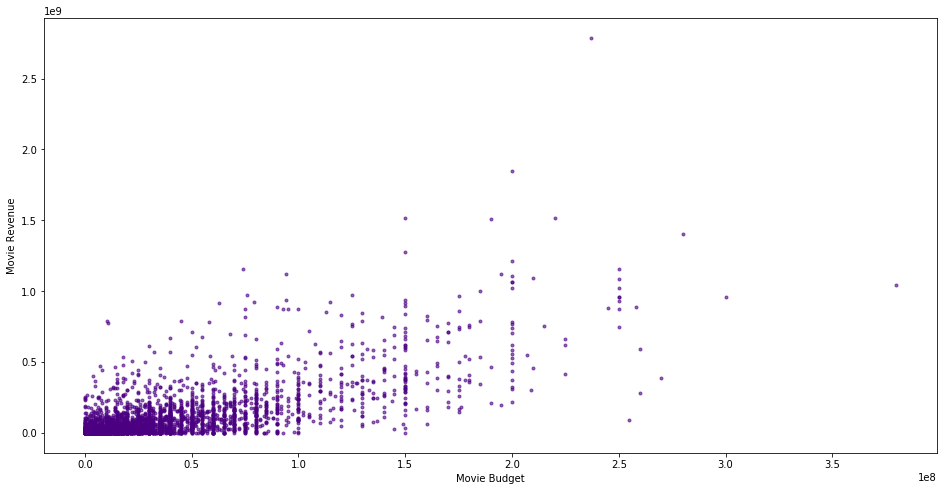

In [29]:
#https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.scatter.html
#https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html
x = tmdb_5000_movies['budget']
y = tmdb_5000_movies['revenue']

fig= plt.figure(figsize=(16,8))

#plt.title('Movies Budget vs Revenue')
plt.xlabel('Movie Budget')
plt.ylabel('Movie Revenue')

plt.scatter(x, y, marker='.', alpha=0.6, color='indigo')

plt.savefig('../static/images/plot1.png')

plt.show()

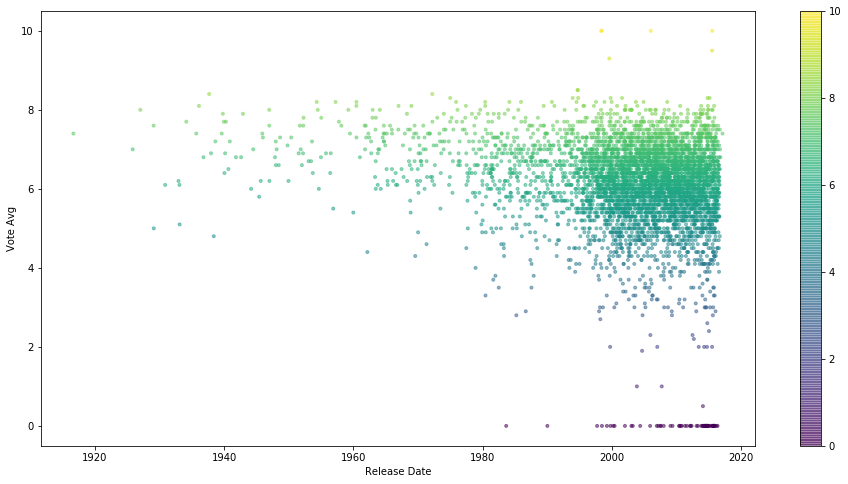

In [27]:
#https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html

x = tmdb_5000_movies['releaseDate']
y = tmdb_5000_movies['vote_average']
colors = tmdb_5000_movies['vote_average']

fig= plt.figure(figsize=(16,8))

#plt.title('Movies Avg. Vote by Year')
plt.xlabel('Release Date')
plt.ylabel('Vote Avg')

plt.scatter(x, y,c=colors, marker ='.', alpha=0.5)
plt.colorbar()

plt.savefig('../static/images/plot2.png')

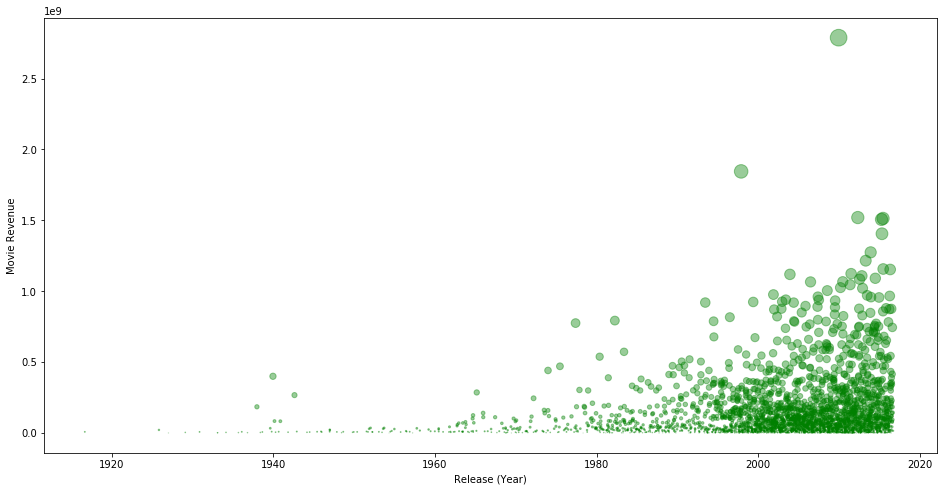

In [25]:
x = tmdb_5000_movies['releaseDate']
y = tmdb_5000_movies['revenue']

fig= plt.figure(figsize=(16,8))

size = tmdb_5000_movies['revenue']/10000000

#plt.title('Movies Revenue by Year')
plt.xlabel('Release (Year)')
plt.ylabel('Movie Revenue')

plt.scatter(x, y, s=size, alpha=0.4, color='green')

plt.savefig('../static/images/plot3.png')

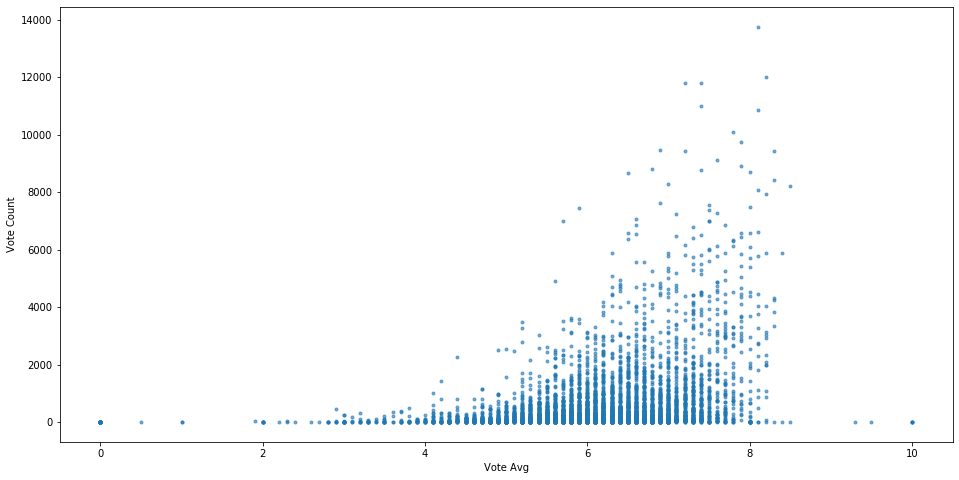

In [26]:
y = tmdb_5000_movies['vote_count']
x = tmdb_5000_movies['vote_average']

fig= plt.figure(figsize=(16,8))

#plt.title('Movies Avg. Vote vs Vote Count')
plt.ylabel('Vote Count')
plt.xlabel('Vote Avg')

plt.scatter(x, y,alpha=0.6, marker ='.')

plt.savefig('../static/images/plot4.png')

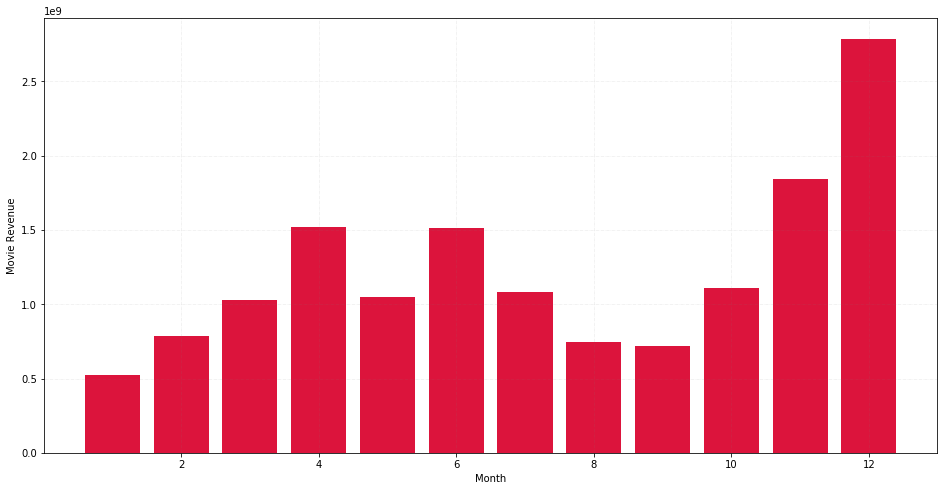

In [24]:
x = tmdb_5000_movies['month']
y = tmdb_5000_movies['revenue']

fig= plt.figure(figsize=(16,8))

#plt.title('Movies Revenue by Month Released')
plt.xlabel('Month')
plt.ylabel('Movie Revenue')

plt.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

plt.bar(x, y, color='crimson')
plt.savefig('../static/images/plot5.png')

plt.show()